In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Set device to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

############################
# Gumbel & Sinkhorn Utils
############################

def sample_gumbel(shape, eps=1e-10, device=torch.device("cuda")):
    U = torch.rand(shape, device=device)
    return -torch.log(-torch.log(U + eps) + eps)

def sinkhorn(log_alpha, n_iters=50, clamp_range=(-15, 15), tol=1e-6):
    log_alpha = torch.clamp(log_alpha, clamp_range[0], clamp_range[1])
    alpha = torch.exp(log_alpha)
    for _ in range(n_iters):
        alpha_prev = alpha.clone()
        alpha = alpha / (alpha.sum(dim=-1, keepdim=True) + 1e-8)
        alpha = alpha / (alpha.sum(dim=-2, keepdim=True) + 1e-8)
        if torch.all(torch.abs(alpha - alpha_prev) < tol):
            break
    return alpha

def straight_through_permutation(soft_perm, device):
    with torch.no_grad():
        hard_perm = torch.zeros_like(soft_perm)
        indices = torch.argmax(soft_perm, dim=-1)
        batch_idx = torch.arange(soft_perm.size(0), device=device).unsqueeze(-1)
        row_idx = torch.arange(soft_perm.size(1), device=device).unsqueeze(0)
        hard_perm[batch_idx, row_idx, indices] = 1.0
    return hard_perm + (soft_perm - soft_perm.detach())

def is_perfect_permutation_matrix(matrix, tol=1e-6):
    """Check if the matrix is a perfect permutation matrix."""
    row_sums = matrix.sum(dim=-1)
    col_sums = matrix.sum(dim=-2)
    binary_check = torch.all((matrix == 0) | (matrix == 1))
    row_sum_check = torch.allclose(row_sums, torch.ones_like(row_sums), atol=tol)
    col_sum_check = torch.allclose(col_sums, torch.ones_like(col_sums), atol=tol)
    return binary_check and row_sum_check and col_sum_check

#############################################################
# Custom Single-Head Attention
#############################################################

class CustomSelfAttention(nn.Module):
    def __init__(self, d_model, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.WQ = nn.Linear(d_model, d_model, bias=False)
        self.WK = nn.Linear(d_model, d_model, bias=False)
        self.WV = nn.Linear(d_model, d_model, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, n, d = x.shape
        Q = self.WQ(x)
        K = self.WK(x)
        V = self.WV(x)
        scores = torch.bmm(Q, K.transpose(1, 2)) / (d ** 0.5)
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        attn_out = torch.bmm(attn_weights, V)
        return scores, attn_out

#########################################
# Transformer Block
#########################################

class TransformerBlock(nn.Module):
    def __init__(self, d_model, dim_feedforward=8192, dropout=0.1):
        super().__init__()
        self.self_attn = CustomSelfAttention(d_model, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, d_model),
        )
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, alpha=0.5):
        B, n, d = x.shape
        scores, attn_out = self.self_attn(x)
        identity = torch.eye(n, device=x.device).unsqueeze(0).repeat(B, 1, 1)
        scores = scores + alpha * identity
        x = self.norm1(x + self.dropout(attn_out))
        ff_out = self.ff(x)
        x = self.norm2(x + self.dropout(ff_out))
        return scores, x

############################
# Gumbel-Sinkhorn Network
############################

class GumbelSinkhornPermutationNet(nn.Module):
    def __init__(self, n=800, d=2048, hidden=8192, num_layers=4, sinkhorn_iters=50):
        super().__init__()
        self.n = n
        self.d = d
        self.blocks = nn.ModuleList([
            TransformerBlock(d, hidden) for _ in range(num_layers)
        ])
        self.sinkhorn_iters = sinkhorn_iters
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            nn.init.ones_(module.weight)
            nn.init.zeros_(module.bias)

    def forward(self, tokens, tau=1.0, alpha=0.5, hard=False):
        B, N, D = tokens.shape
        assert N == self.n and D == self.d, "Input size must match model config"

        x = tokens
        scores = None
        for block in self.blocks:
            scores, x = block(x, alpha=alpha)

        gumbel_noise = sample_gumbel(scores.shape, device=tokens.device)
        log_alpha = (scores + gumbel_noise) / tau
        soft_perm = sinkhorn(log_alpha, n_iters=self.sinkhorn_iters)
        if hard:
            return straight_through_permutation(soft_perm, tokens.device)
        return soft_perm

############################
# Loss Function
############################

def permutation_loss(pred, target, beta=1.0, entropy_weight=0.01):
    mse_loss = F.mse_loss(pred, target)
    ce_loss = -torch.sum(target * torch.log(pred + 1e-8), dim=-1).mean()
    entropy = -torch.sum(pred * torch.log(pred + 1e-8), dim=-1).mean()
    return mse_loss + beta * ce_loss + entropy_weight * entropy

############################
# Training Loop
############################

def create_random_permutation_matrix(n, device=torch.device("cuda")):
    perm = torch.randperm(n, device=device)
    mat = torch.zeros(n, n, device=device)
    mat[torch.arange(n, device=device), perm] = 1.0
    return mat

def create_toy_dataset(batch_size=4, n=800, d=2048, device=torch.device("cuda")):
    tokens = torch.randn(batch_size, n, d, device=device)
    targets = torch.stack([create_random_permutation_matrix(n, device=device) for _ in range(batch_size)], dim=0)
    return tokens, targets

def compute_accuracy(pred_perm, target_perm):
    """Compute accuracy by comparing argmax indices of predicted and target permutation matrices."""
    pred_indices = torch.argmax(pred_perm, dim=-1)  # [B, n]
    target_indices = torch.argmax(target_perm, dim=-1)  # [B, n]
    correct = (pred_indices == target_indices).float().mean()  # Fraction of correct matches
    return correct.item() * 100  # Convert to percentage

def train_example(steps=5000, batch_size=4, n=800, d=2048, lr=1e-4, tau_start=2.0, tau_end=0.1, alpha=0.5, hidden=8192):
    model = GumbelSinkhornPermutationNet(n=n, d=d, hidden=hidden, num_layers=4, sinkhorn_iters=50).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=steps)

    tokens, target_perms = create_toy_dataset(batch_size, n, d, device=device)

    for step in range(steps):
        optimizer.zero_grad()
        current_tau = tau_end + 0.5 * (tau_start - tau_end) * (1 + torch.cos(torch.tensor(step / steps * 3.14159, device=device)))
        approx_perm = model(tokens, tau=current_tau, alpha=alpha, hard=(step > steps // 2))

        loss = permutation_loss(approx_perm, target_perms, beta=1.0, entropy_weight=0.01)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        optimizer.step()
        scheduler.step()

        # Compute training accuracy
        with torch.no_grad():
            hard_perm = straight_through_permutation(approx_perm, device)
            accuracy = compute_accuracy(hard_perm, target_perms)

        if (step + 1) % (steps // 10) == 0:
            print(f"Step {step + 1}/{steps}, Loss={loss.item():.6f}, Tau={current_tau.item():.6f}, Training Accuracy={accuracy:.2f}%")

    with torch.no_grad():
        final_perm = model(tokens, tau=tau_end, alpha=alpha, hard=True)
        # Verify if final_perm is a perfect permutation matrix
        is_perfect = is_perfect_permutation_matrix(final_perm)
        print(f"\nFinal permutation matrix is perfect: {is_perfect}")

    return final_perm, target_perms

if __name__ == "__main__":
    final_mats, targets = train_example(
        steps=1000,
        batch_size=4,
        n=1000,
        d=2048,
        lr=1e-4,
        tau_start=2.0,
        tau_end=0.1,
        alpha=0.5,
        hidden=8192
    )
    print("\nFinal Learned Permutations (First Sample, first 10x10 block):")
    print(final_mats[0, :10, :10].cpu())
    print("\nTarget Permutation (First Sample, first 10x10 block):")
    print(targets[0, :10, :10].cpu())

Using device: cuda
Step 100/1000, Loss=0.000542, Tau=1.954422, Training Accuracy=100.00%


KeyboardInterrupt: 

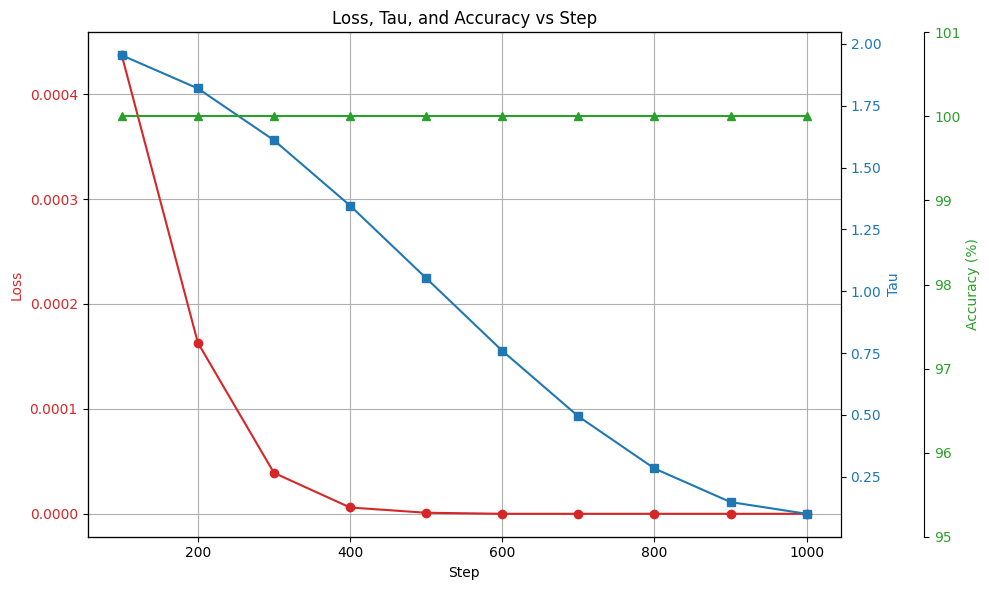

In [ ]:
import matplotlib.pyplot as plt

# Raw log lines
log_lines = [
    "Step 100/1000, Loss=0.000437, Tau=1.954422, Training Accuracy=100.00%",
    "Step 200/1000, Loss=0.000163, Tau=1.820317, Training Accuracy=100.00%",
    "Step 300/1000, Loss=0.000039, Tau=1.610808, Training Accuracy=100.00%",
    "Step 400/1000, Loss=0.000006, Tau=1.346404, Training Accuracy=100.00%",
    "Step 500/1000, Loss=0.000001, Tau=1.052986, Training Accuracy=100.00%",
    "Step 600/1000, Loss=0.000000, Tau=0.759275, Training Accuracy=100.00%",
    "Step 700/1000, Loss=0.000000, Tau=0.494023, Training Accuracy=100.00%",
    "Step 800/1000, Loss=0.000000, Tau=0.283193, Training Accuracy=100.00%",
    "Step 900/1000, Loss=0.000000, Tau=0.147424, Training Accuracy=100.00%",
    "Step 1000/1000, Loss=0.000000, Tau=0.100005, Training Accuracy=100.00%"
]

# Parse values
steps, losses, taus, accuracies = [], [], [], []
for line in log_lines:
    parts = line.split(", ")
    steps.append(int(parts[0].split()[1].split('/')[0]))
    losses.append(float(parts[1].split('=')[1]))
    taus.append(float(parts[2].split('=')[1]))
    accuracies.append(float(parts[3].split('=')[1].replace('%', '')))

# Create a figure with multiple y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Primary y-axis: Loss
color1 = 'tab:red'
ax1.set_xlabel('Step')
ax1.set_ylabel('Loss', color=color1)
ax1.plot(steps, losses, color=color1, marker='o', label='Loss')
ax1.tick_params(axis='y', labelcolor=color1)

# Secondary y-axis: Tau
ax2 = ax1.twinx()
color2 = 'tab:blue'
ax2.set_ylabel('Tau', color=color2)
ax2.plot(steps, taus, color=color2, marker='s', label='Tau')
ax2.tick_params(axis='y', labelcolor=color2)

# Tertiary y-axis: Accuracy
ax3 = ax1.twinx()
color3 = 'tab:green'
ax3.spines['right'].set_position(('outward', 60))  # Offset third axis
ax3.set_ylabel('Accuracy (%)', color=color3)
ax3.plot(steps, accuracies, color=color3, marker='^', label='Accuracy')
ax3.tick_params(axis='y', labelcolor=color3)
ax3.set_ylim([95, 101])  # Since accuracy is 100%

# Title and grid
plt.title("Loss, Tau, and Accuracy vs Step")
ax1.grid(True)

# Show plot
fig.tight_layout()
plt.show()



In [ ]:
print("\nFinal Learned Permutations (First Sample, first 10x10 block):")
print(final_mats[0, :100, :100].cpu())
print("\nTarget Permutation (First Sample, first 10x10 block):")
print(targets[0, :100, :100].cpu())


Final Learned Permutations (First Sample, first 10x10 block):
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [ ]:
torch.set_printoptions(threshold=1000000, edgeitems=1000, linewidth=200)